The BDF4 Method

In [ ]:
from assimulo.explicit_ode import Explicit_ODE
from assimulo.ode import *
import numpy as np
import matplotlib.pyplot as mpl
import scipy.linalg as SL
from assimulo.solvers import CVode
import assimulo.problem as apro

class BDF4Felix(Explicit_ODE):
    
    #Define variables
    tol=1.e-8     
    maxit=100     
    maxsteps=500
    
    def __init__(self, problem): #Initialize the class
        Explicit_ODE.__init__(self, problem) #Calls the base class
        
        #Solver options
        self.options["h"] = 0.01
        
        #Statistics
        self.statistics["nsteps"] = 0
        self.statistics["nfcns"] = 0
    
    def _set_h(self,h):
            self.options["h"] = float(h)

    def _get_h(self):
        return self.options["h"]
        
    h=property(_get_h,_set_h) #Allows to get and set h as a property
    
    def jacobian_fd(self, t, y):
        """
        Compute the Jacobian using finite differences.
        Works for any function without requiring analytical derivatives.
        """
        eps = 1e-8
        n = len(y)
        J = np.zeros((n, n))
        
        # Evaluate RHS at base point
        f = self.problem.rhs(t, y)
        
        # Finite difference for each column
        for j in range(n):
            y_perturbed = y.copy()
            y_perturbed[j] += eps
            f_perturbed = self.problem.rhs(t, y_perturbed)
            J[:, j] = (f_perturbed - f) / eps
        
        return J
    
    def integrate(self, t, y, tf, opts):
        """
        _integrates (t,y) values until t > tf
        """
        h = self.options["h"]
        h = min(h, abs(tf-t))
        
        #Lists for storing the result
        tres = []
        yres = []
        
        t_nm1,t_nm2,t_nm3= 0, 0, 0
        y_nm1,y_nm2,y_nm3= 0, 0, 0
        
        for i in range(self.maxsteps):
            if t >= tf:
                break
            self.statistics["nsteps"] += 1
            
            if i==0:  # initial step
                t_np1,y_np1 = self.step_EE(t,y, h)
            elif i==1:
                t_np1, y_np1 = self.step_BDF2([t, t_nm1], [y, y_nm1], h)
            elif i==2: 
                t_np1, y_np1 = self.step_BDF3([t, t_nm1, t_nm2], [y, y_nm1, y_nm2], h)
            else:   
                t_np1, y_np1 = self.step_BDF4([t,t_nm1, t_nm2, t_nm3], [y,y_nm1, y_nm2, y_nm3], h)
            t,t_nm1,t_nm2,t_nm3=t_np1,t,t_nm1,t_nm2
            y,y_nm1,y_nm2,y_nm3=y_np1,y,y_nm1,y_nm2
            
            tres.append(t)
            yres.append(y.copy())
        
            h=min(self.h,np.abs(tf-t))
        else:
            raise Explicit_ODE_Exception('Final time not reached within maximum number of steps')
        
        return ID_PY_OK, tres, yres
    
    def step_EE(self, t, y, h):
        """
        This calculates the next step in the integration with explicit Euler.
        """
        self.statistics["nfcns"] += 1
        
        f = self.problem.rhs
        return t + h, y + h*f(t, y) 
        
    def step_BDF2(self,T,Y, h):
        """
        BDF-2 with Fixed Point Iteration and Zero order predictor
        
        alpha_0*y_np1+alpha_1*y_n+alpha_2*y_nm1=h f(t_np1,y_np1)
        alpha=[3/2,-2,1/2]
        """
        alpha=[3./2.,-2.,1./2]
        f=self.problem.rhs
        
        t_n,t_nm1=T
        y_n,y_nm1=Y
        # predictor
        t_np1=t_n+h
        y_np1_i=y_n   # zero order predictor
        # corrector with fixed point iteration
        for i in range(self.maxit):
            self.statistics["nfcns"] += 1
            
            # Define the residual
            G = alpha[0]*y_np1_i - h*f(t_np1,y_np1_i) + alpha[1]*y_n + alpha[2]*y_nm1
            #Define the Jacobian of the residual
            J = alpha[0]*np.eye(len(y_n)) - h*self.jacobian_fd(t_np1,y_np1_i)
        
            delta_y = SL.solve(J, -G)
            y_np1_ip1= y_np1_i + delta_y
            
            if SL.norm(delta_y) < self.tol:
                return t_np1,y_np1_ip1
            y_np1_i=y_np1_ip1
        else:
            raise Explicit_ODE_Exception('Corrector could not converge within % iterations'%i)
    
    def step_BDF3(self,T,Y, h):
        alpha = [11./6., -3., 3./2., -1./3.]
        
        t_n, t_nm1, t_nm2 = T
        y_n, y_nm1, y_nm2 = Y
        # predictor
        t_np1 = t_n + h
        y_np1_i = y_n  # zero order predictor
        # corrector with fixed point iteration
        for i in range(self.maxit):
            self.statistics["nfcns"] += 1
            
            #Define the residual
            G = alpha[0]*y_np1_i - h*self.problem.rhs(t_np1,y_np1_i) + alpha[1]*y_n + alpha[2]*y_nm1 + alpha[3]*y_nm2
            #Define the Jacobian of the residual
            J = alpha[0]*np.eye(len(y_n)) - h*self.jacobian_fd(t_np1,y_np1_i)
            
            delta_y = SL.solve(J, -G)
            y_np1_ip1 = y_np1_i + delta_y
            if SL.norm(delta_y) < self.tol:
                return t_np1, y_np1_ip1
            y_np1_i = y_np1_ip1
        else:
            raise Explicit_ODE_Exception('Corrector could not converge within % iterations' % i)
        
    def step_BDF4(self,T,Y, h):
        alpha = [25./12., -4., 3., -4./3., 1./4.]
        
        t_n, t_nm1, t_nm2, t_nm3 = T
        y_n, y_nm1, y_nm2, y_nm3 = Y
        # predictor
        t_np1 = t_n + h
        y_np1_i = y_n  # zero order predictor
        # corrector with fixed point iteration
        for i in range(self.maxit):
            self.statistics["nfcns"] += 1
            
            #Define the residual
            G = alpha[0]*y_np1_i - h*self.problem.rhs(t_np1,y_np1_i) + alpha[1]*y_n + alpha[2]*y_nm1 + alpha[3]*y_nm2 + alpha[4]*y_nm3
            #Define the Jacobian of the residual
            J = alpha[0]*np.eye(len(y_n)) - h*self.jacobian_fd(t_np1,y_np1_i)
            
            delta_y = SL.solve(J, -G)
            y_np1_ip1 = y_np1_i + delta_y
            if SL.norm(delta_y) < self.tol:
                return t_np1, y_np1_ip1
            y_np1_i = y_np1_ip1
        else:
            raise Explicit_ODE_Exception('Corrector could not converge within % iterations' % i)
    
    def print_statistics(self, verbose=NORMAL):
        self.log_message('Final Run Statistics            : {name} \n'.format(name=self.problem.name),        verbose)
        self.log_message(' Step-length                    : {stepsize} '.format(stepsize=self.options["h"]), verbose)
        self.log_message(' Number of Steps                : '+str(self.statistics["nsteps"]),          verbose)               
        self.log_message(' Number of Function Evaluations : '+str(self.statistics["nfcns"]),         verbose)
            
        self.log_message('\nSolver options:\n',                                    verbose)
        self.log_message(' Solver            : BDF2',                     verbose)
        self.log_message(' Solver type       : Fixed step\n',                      verbose)


Defining the pendulum problem

In [10]:
k=1

def pendulum(t, x):
    xvec = np.zeros_like(x)
    xvec[0] = x[2]
    xvec[1] = x[3]
    xvec[2] = - x[0] * k * (np.sqrt(x[0]**2 + x[1]**2) + 1) / np.sqrt(x[0]**2 + x[1]**2)
    xvec[3] = - x[1] * k * (np.sqrt(x[0]**2 + x[1]**2) + 1) / np.sqrt(x[0]**2 + x[1]**2)
    return xvec

pendulum_Problem = apro.Explicit_Problem(pendulum, t0 = 0, y0 = np.array([1, 1, 1, 1]))
pendulum_Problem.name = 'Pendulum Problem with k={}'.format(k)

Testing the method

Final Run Statistics            : Pendulum Problem with k=1 

 Step-length                    : 0.01 
 Number of Steps                : 401
 Number of Function Evaluations : 802

Solver options:

 Solver            : BDF2
 Solver type       : Fixed step

Simulation interval    : 0.0 - 4.0 seconds.
Elapsed simulation time: 0.05116258398629725 seconds.


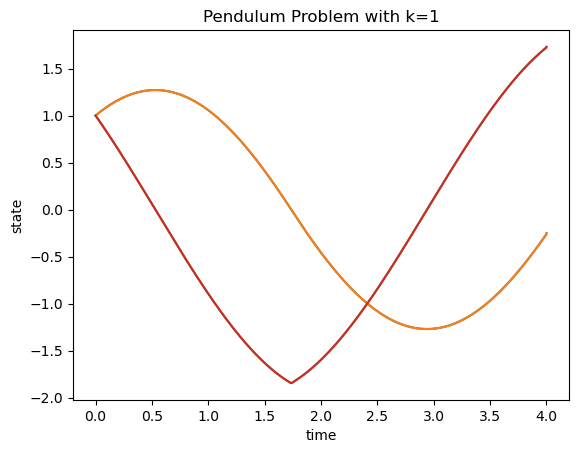

In [15]:
exp_sim = BDF4Felix(pendulum_Problem) #Create a BDF solver
t, y = exp_sim.simulate(4)
exp_sim.plot()
mpl.show()